# Estimando o viés de uma moeda

### GB-500-TEMC: Modelos Compartimentais em Epidemiologia e Inferência Bayesiana

#### João Pedro Valeriano Miranda

In [1]:
print("Versões dos Pacotes:")
print("--------------------")
!pip list | grep -E numpy\|scipy\|matplotlib

Versões dos Pacotes:
--------------------
matplotlib           3.5.1
matplotlib-inline    0.1.3
numpy                1.22.0
scipy                1.7.3


## 1. Análise exploratória

Vamos considerar uma moeda representada por sorteios aleatórios de 0s e 1s (caras e coroas) com mesma probabilidade. A partir deste experimento numérico, vamos avaliar como varia a flutuação frequência relativa de caras nos resultados dos lançamentos, a medida que aumentamos a quantidade de lançamentos. Neste contexto, vamos denominar a frequência relativa de caras como o $\textbf{viés}$ da moeda. Para uma moeda equilibrada, devemos ter um viés de 0.5, é claro.

Primeiramente, para diferentes números $N$ de sorteios, vamos repetir estes $N$ sorteios várias vezes para gerar uma distribuição da frequência de caras por sorteio.

In [2]:
import numpy as np # arrays etc
from math import factorial as fact # fatorial
import matplotlib.pyplot as plt # gráficos
from scipy.optimize import curve_fit # ajuste de curva
from scipy.integrate import simps # método de Simpson para integral
from scipy.special import binom # binômio de Newton

In [3]:
# Fixando seed dos números aleatórios
np.random.seed(123456789)

In [4]:
nruns = 1000 # Número de repetições do conjunto de sorteios da moeda

N = np.array([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]) # Números de jogadas para os quais vamos plotar a posterior

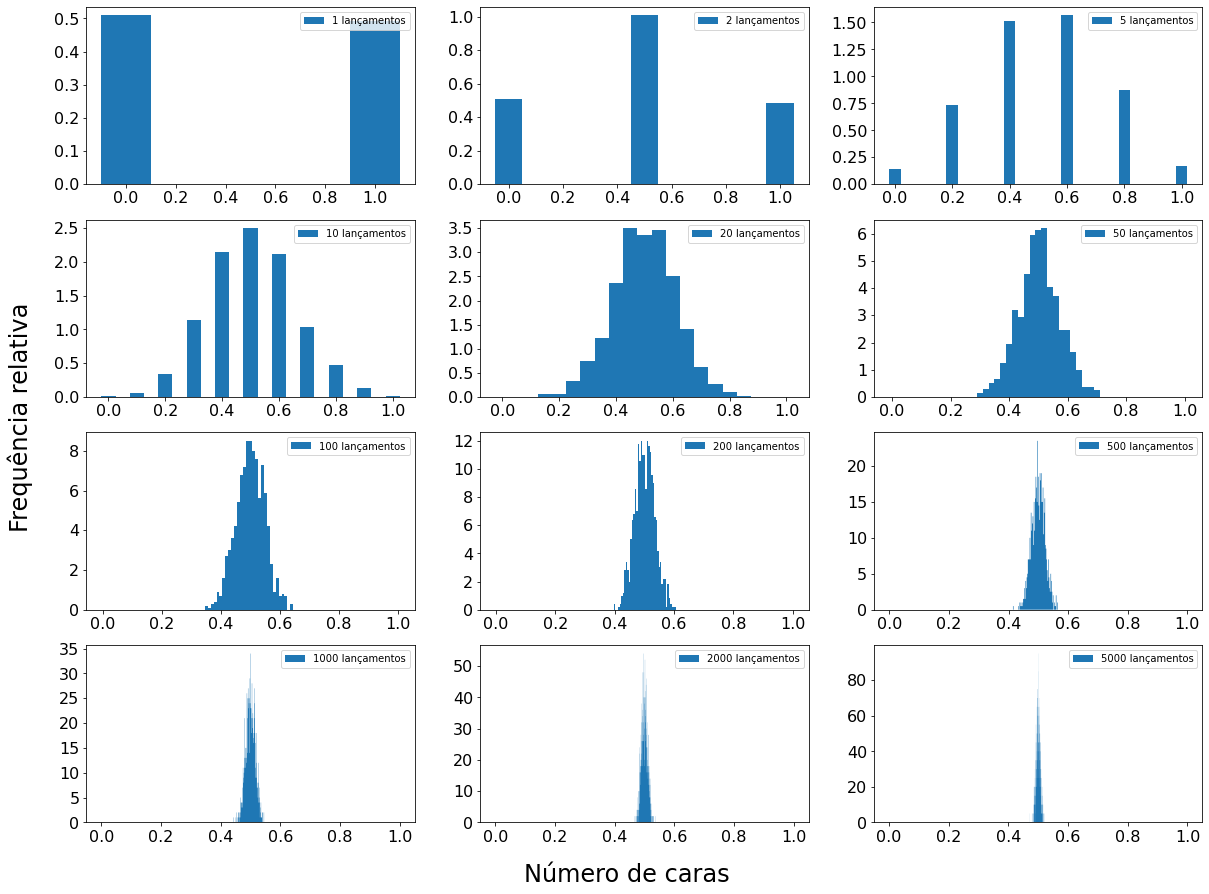

In [5]:
fig, ax = plt.subplots(4, 3, figsize=(20,15)) # Criando figura
fig.text(0.07, 0.5, "Frequência relativa", fontsize=24, va="center", rotation="vertical")
fig.text(0.5, 0.07, "Número de caras", fontsize=24, ha="center")

freq_mean = [] # Array para armazenar frequência média de caras
freq_std = [] # Array para armazenar o desvio padrão da frequência média de caras

# loop adicionando jogadas da moeda
for n in N:
    freq_caras = [(n-np.sum(np.random.randint(0,2,n)))/n for i in range(nruns)]
    
    freq_mean.append(np.mean(freq_caras)) # frequência média de caras
    freq_std.append(np.std(freq_caras)) # desvio padrão da média da frequência de caras
    
    # Plotagem
    plt.subplot(4, 3, np.where(N==n)[0][0]+1)
    
    # Diferentes tweaks dos histogramas a depender da quantidade de samples
    if n <= 5:
        plt.hist(freq_caras, bins=np.arange(-0.5, n+1.5)/n, rwidth=0.2, histtype="bar", density=True, label=f"{n} lançamentos")
    elif n <= 10:
        plt.hist(freq_caras, bins=np.arange(-0.5, n+1.5)/n, rwidth=0.5, histtype="bar", density=True, label=f"{n} lançamentos")
    else:
        plt.hist(freq_caras, bins=np.arange(-0.5, n+1.5)/n, histtype="stepfilled", density=True, label=f"{n} lançamentos")
    
    plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylim(0)
    plt.legend(loc="upper right", fontsize=10)

plt.show()

Como podemos ver, a medida que aumentamos o número de lançamentos, temos uma redução no desvio padrão da distribuição, obtendo maior precisão sobre o viés da moeda. Podemos fazer o gráfico do desvio padrão do viés em função do número de lançamentos. Em escala log-log, obtemos uma relação linear, o que implica que o desvio padrão decai com uma lei de potência:

\begin{equation}
f_{caras} = A N^{B}
\label{eq:freq_power_law} \tag{1}
\end{equation}

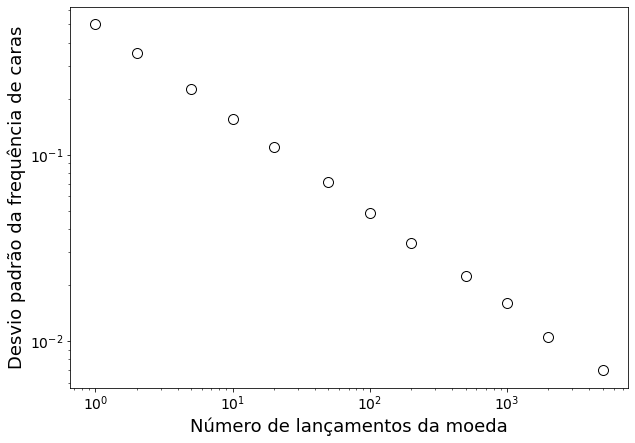

In [6]:
# Gráfico do desvio padrão por N
plt.figure(figsize=(10,7))
plt.scatter(N, freq_std, s=100, edgecolor="k", facecolor="w")
plt.xlabel("Número de lançamentos da moeda", fontsize=18)
plt.ylabel("Desvio padrão da frequência de caras", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xscale("log")
plt.yscale("log")

# mostrar figura
plt.show()

# ou salvar figura
# plt.savefig("std_vs_N_loglog.png", dpi=300, bbox_inches="tight")
# plt.close()

Vamos determinar os coeficientes da lei de potência.

In [7]:
def linear(x, a, b):
    return a + b*x

params = curve_fit(linear, np.log(N), np.log(freq_std))

a, b = params[0]
print(f"a = {a}; b = {b}")
A = np.exp(a)
B = b

print(f"A = {A}; B = {B}")

a = -0.694513211316848; b = -0.5027703657896008
A = 0.49931745091920604; B = -0.5027703657896008


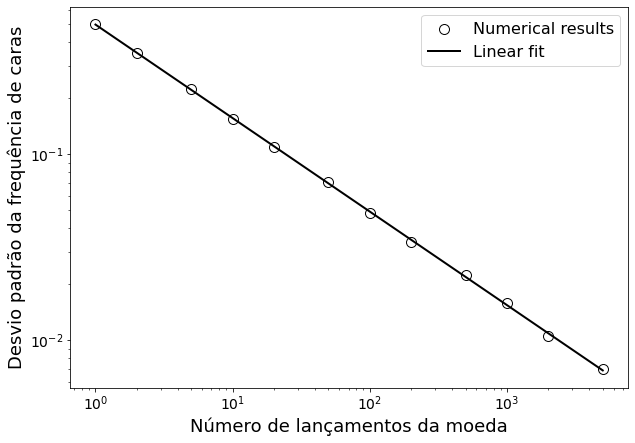

In [8]:
# Gráfico do ajuste do desvio padrão por N
plt.figure(figsize=(10,7))
plt.scatter(N, freq_std, s=100, edgecolor="k", facecolor="w", label="Numerical results")
plt.plot(N, A*N**B, lw=2, c="k", label="Linear fit")
plt.xlabel("Número de lançamentos da moeda", fontsize=18)
plt.ylabel("Desvio padrão da frequência de caras", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xscale("log")
plt.yscale("log")
plt.legend(loc="upper right", fontsize=16)

# mostrar figura
plt.show()

# ou salvar figura
# plt.savefig("ajuste_std_vs_N_loglog.png", dpi=300, bbox_inches="tight")
# plt.close()

Concluímos que $B \approx -1/2$, como é de se esperar, uma vez que o número de caras deve seguir uma distribuição binomial, com desvio padrão proporcional a $\sqrt{N}$. Portanto, se dividimos o número de caras pelo número de lançamentos $N$, devemos obter um desvio padrão proporcional a $\sqrt{N}/N = N^{-1/2}$.

## 2. Inferência Bayesiana

A partir dos resultados de lançamentos da moeda, podemos inferir o seu viés, que será denotado por $v$.

Dado tal viés, a probabilidade de esta moeda retornar y caras em N jogadas é dada pela distribuição binomial de taxa de sucesso v e número de tentativas N. Esta é a likelihood:
    
\begin{equation*}
P(y|v, N) = \frac{N!}{y! (N-y)!} v^{y} (1-v)^{N-y}.
\tag{2}
\end{equation*}

Se não temos nenhuma informação sobre o viés da moeda, utilizamos uma prior uniforme:
    
\begin{equation*}    
P(v) = U(0, 1).
\tag{3}
\end{equation*}

Considerando a likelihood marginal P(y) como apenas uma normalização, a menos disto, temos a distribuição posterior:
    
\begin{equation*}    
P(v|y, N) = \frac{N!}{y!(N-y)!} v^{y}  (1-v)^{N-y}, \; 0 \leq v \leq 1.
\end{equation*}
    
Vamos sortear várias jogadas da moeda, como 0s e 1s uniformemente distribuídos, e e gerar a distribuição posterior a partir dos resultados. Vamos seguir a notação $0\rightarrow$ Cara, $1\rightarrow$ Coroa.

Vale notar que, para grandes valores de $N$ e $y$, não é possível computar a distribuição binomial. Felizmente, para grandes valores de $N$, podemos aproximar a distribuição binomial por uma distribuição normal, de média $Nv$ e variância $Nv(1-v)$. É isto que faremos nos casos em que o binômio se torna grande demais para o computador.

In [9]:
# Fixando seed dos números aleatórios
np.random.seed(123456789)

In [10]:
# PDF da distribuição normal, para uso como aproximação da distribuiçãobinomial, 
# no caso de grande número de tentativas.
def normal_pdf(v, y, N):
    
    return np.exp(-(y-N*v)**2/(N*v*(1-v))/2)/np.sqrt(2*np.pi*N*v*(1-v))

# PDF da distribuição binomial
def binom_pdf(v, y, N):
    
    # Se N e y forem grandes demais para o cálculo numérico do binômio de Newton, 
    # aproximamos a PDF por uma gaussiana, como é sabido pelo Teorema de 
    # De Moivre-Laplace
    if binom(N, y) != np.inf:
        return binom(N, y)*v**y*(1-v)**(N-y)
    
    else:
        print(f"** PDF para {N} jogadas gerada através de aproximação pela distribuição normal. **")
        return normal_pdf(v, y, N)

In [11]:
v = np.linspace(0, 1, 1000)[1:-1] # Intervalo em que consideramos o possível viés da moeda

N = [0, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000] # Números de jogadas para os quais vamos plotar a posterior

** PDF para 2000 jogadas gerada através de aproximação pela distribuição normal. **


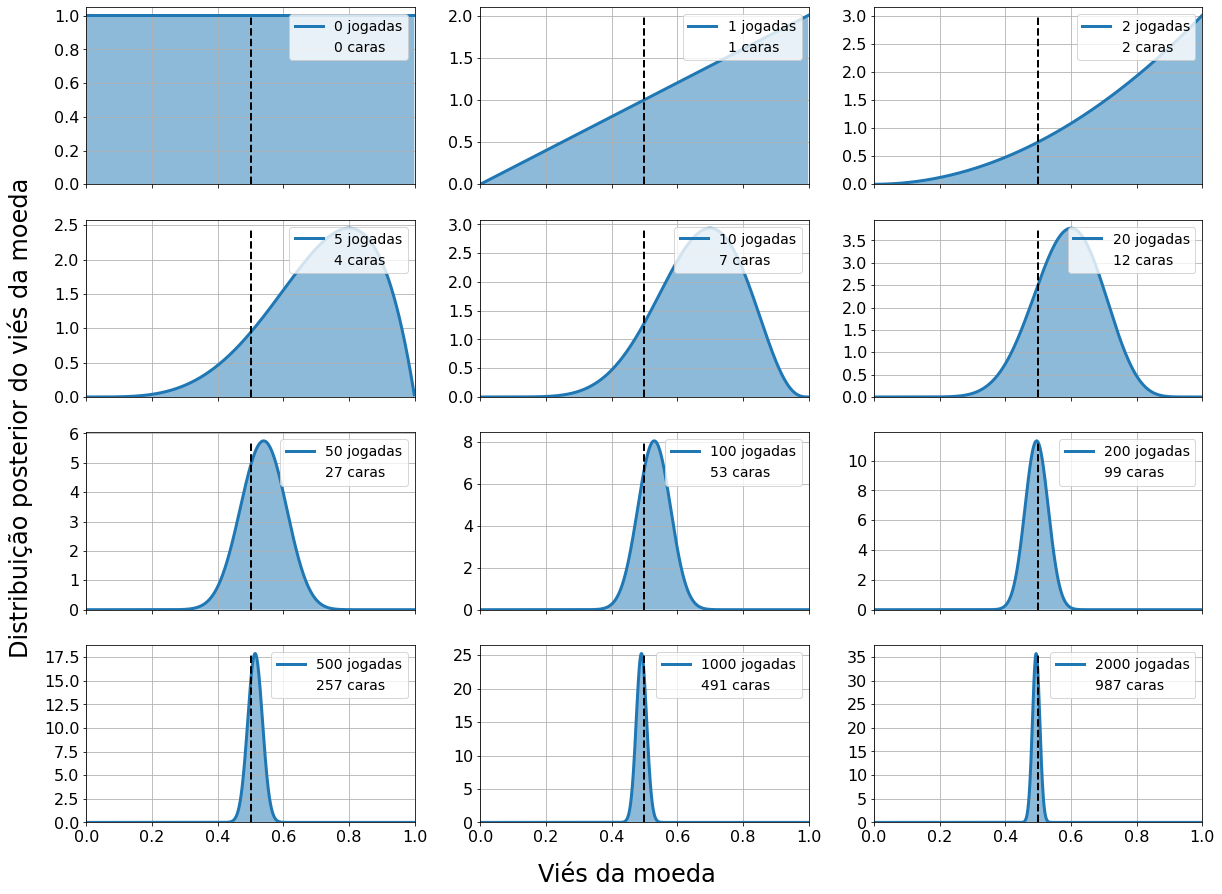

In [12]:
fig, ax = plt.subplots(4, 3, figsize=(20,15), sharex=True) # Criando figura
fig.text(0.07, 0.5, "Distribuição posterior do viés da moeda", fontsize=24, va="center", rotation="vertical")
fig.text(0.5, 0.07, "Viés da moeda", fontsize=24, ha="center")

caras = 0 # Número inicial de caras

# loop adicionando jogadas da moeda
for n in range(0, N[-1]+1):
    if n in N: # se o número de jogadas atual deve ser plotado, o fazemos
        pdf = binom_pdf(v, caras, n) # PDF da dist. binomial
        
        # normalização da distribuição
        norm = simps(pdf, v)
        pdf /= norm
        
        # Plotagem
        plt.subplot(4, 3, N.index(n)+1)
        plt.plot(v, pdf, lw=3, label=f"{n} jogadas")
        plt.plot([], [], " ", label=f"{caras} caras")
        plt.fill_between(v, pdf, alpha=0.5)
        plt.vlines(0.5, 0, np.max(pdf), "k", "--", lw=2)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.xlim(0, 1)
        plt.ylim(0)
        plt.grid()
        plt.legend(loc="upper right", fontsize=14)
    
    # n-ésima jogada
    caras += 1 - np.random.randint(0, 2)
    
# mostrar figura
plt.show()

# ou salvar figura
# plt.savefig("vies_moeda_posterior.png", dpi=300, bbox_inches="tight")
# plt.close()